# Redução e ampliação de dimensão

Uma planilha, em termos dimensionais, possue duas dimensões (número de linhas e número de colunas). **Alta Dimensão** é ruim, por questões de desempenho dos modelos de aprendizado de máquina. No entanto, **Baixa Dimensão** é ruim, por não revelar todos os padrões com confiança estatística mínima para tomada de decisões. 

Em relação ao métodos, existem métodos lineares e não lineares.

Em relação aos métodos de redução de dimensão, existem **engenharia de variáveis** e **seleção de variáveis**.

### Sumário

- Redução de dimensão
    - Seleção de variáveis
        - Exclusão de poucas correlacionadas com a variável de interesse
        - Exclusão de variáveis correlacionadas
        - Exclusão de variáveis pouco importantes
        - Kbest
        - Variance Threshold
        - Select From Model
        - Outros métodos
    - Engenharia de variáveis (uso do conhecimento de negócio para extração de novas características)
    - Transformações
        - PCA
        - PCA kernel
        - Outros métodos
- Ampliação de dimensão
    - SMOTE

### Bibliotecas

In [222]:
# data structure
import pandas as pd
import numpy as np
import math

# stats
from scipy.stats import skew

# feature selection
from sklearn.feature_selection import SelectKBest, r_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

# feature transfoms
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import PolynomialFeatures

# target balance
from imblearn.over_sampling import SMOTE, ADASYN

# visual info
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# model selection
from sklearn.model_selection import train_test_split

# models
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

### Baseline (House prices)

Lembremos como foi o pré-processamento do conjunto de dado House Prices (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

In [239]:
# read train and test
train = pd.read_csv('../datasets/housing_prices/train.csv')
test = pd.read_csv('../datasets/housing_prices/test.csv')

# concatenate train and test
all_data = pd.concat(
    (train.loc[:,'MSSubClass':'SaleCondition'],
     test.loc[:,'MSSubClass':'SaleCondition']))

# apply log in target
train["SalePrice"] = np.log1p(train["SalePrice"])

# remove assymetry of numerics
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats]) 

# transform categorics
all_data = pd.get_dummies(all_data)

# fill missed data
all_data = all_data.fillna(all_data.mean())

X = all_data[:train.shape[0]] # Kaggle train
test = all_data[train.shape[0]:] # Kaggle test
y = train.SalePrice # target

# split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=42)

Vejamos qual a dimensão:

In [240]:
all_data.shape

(2919, 287)

Ficamos com 287 colunas!!! Com as ferramentas de hoje o pré-processamento e a modelagem deste conjunto de dados ainda são viáveis. No entanto, em problemas maiores, teremos que reduzir o número de variáveis para conseguirmos rodar o código em tempo hábil de fazer a entrega do modelo. Veremos algumas técnicas. Antes de mais nada, consideraremos alguns modelos como base, veremos importância de variáveis e correlações.

### RMSE do baseline com CatBoost

In [241]:
# train CatBoost
cat = CatBoostRegressor()
cat.fit(X_train, y_train, verbose=False)

# evaluate CatBoost
y_pred = cat.predict(X_test)
mean_squared_error(y_test, y_pred, squared=True)

0.014244880079955231

### RMSE do baseline com Regressão Linear

In [242]:
# train Linear Regression
linear = LinearRegression()
linear.fit(X_train, y_train)

# evaluate Linear Regression
y_pred = linear.predict(X_test)
mean_squared_error(y_test, y_pred, squared=True)

0.018694821647436896

# Redução de dimensão

### Importância de cada variável

In [243]:
cat_importances_df = pd.DataFrame({
    "columns": all_data.columns, 
    "importance": cat.feature_importances_
})
cat_importances_df.sort_values('importance', ascending=False).head(5)

,columns,importance
3,OverallQual,21.687524
15,GrLivArea,14.380249
11,TotalBsmtSF,5.010352
23,Fireplaces,3.922132
8,BsmtFinSF1,3.426744


### Correlação de cada variável com a variável de interesse

In [244]:
df_temp = X.copy()
df_temp['SalePrice'] = y
sale_price_corrs = df_temp.corr()["SalePrice"]

corr_df = pd.DataFrame({
    "columns": sale_price_corrs.index, 
    "correlation": sale_price_corrs.values
})
corr_df.sort_values('correlation', ascending=False).head(5)

,columns,correlation
287,SalePrice,1.000000
3,OverallQual,0.817185
15,GrLivArea,0.730254
25,GarageCars,0.680625
26,GarageArea,0.650888


In [91]:
corr_df.sort_values('correlation', ascending=True).head(5)

,columns,correlation
169,ExterQual_TA,-0.595882
226,KitchenQual_TA,-0.538237
184,BsmtQual_TA,-0.477611
247,GarageFinish_Unf,-0.432012
244,GarageType_Detchd,-0.388638


### Correlação entre colunas

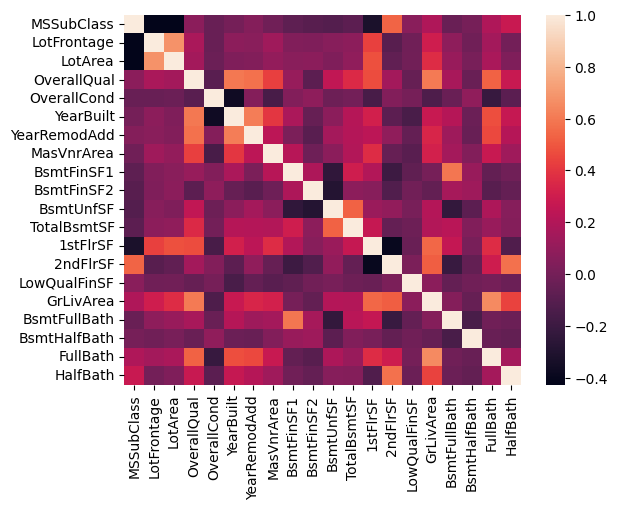

In [92]:
sns.heatmap(all_data.iloc[:,0:20].corr());
plt.show()

Podemos excluir variáveis preditoras que correlacionam com outras, podemos excluir aquelas que não se correlacionam com a variável de interesse e, por fim, podemo excluir aquelas menos importantes. Existem funções na biblioteca Scikit-Learn para tal.

## Seleção de variáveis (Variance Threshold)

In [250]:
selector = VarianceThreshold(0.05) # threshold = 0.22
X_new = selector.fit_transform(X)

In [251]:
X_new.shape

(1460, 119)

In [252]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.25, random_state=42)

In [253]:
# train CatBoost
cat = CatBoostRegressor()
cat.fit(X_train, y_train, verbose=False)

# evaluate CatBoost
y_pred = cat.predict(X_test)
mean_squared_error(y_test, y_pred, squared=True)

0.01522967567551422

In [254]:
# train Linear Regression
linear = LinearRegression()
linear.fit(X_train, y_train)

# evaluate Linear Regression
y_pred = linear.predict(X_test)
mean_squared_error(y_test, y_pred, squared=True)

0.0174897614186863

## Seleção de variáveis (Kbest)

In [255]:
transformer = SelectKBest(r_regression, k=10)

X_new = transformer.fit_transform(X, y)

# split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_new,y,test_size=0.25,random_state=42)

In [256]:
# train CatBoost
model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=False)
y_pred = model.predict(X_test)

print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 10
RMSE: 0.026708006546676516


In [257]:
# train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 10
RMSE: 0.027005315814359013


## Seleção de variáveis (Select From Model)

In [264]:
transformer = SelectFromModel(
    estimator=RandomForestRegressor())
X_new = transformer.fit_transform(X, y)

# split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.25, random_state=42)

In [265]:
# train CatBoost
model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=False)
y_pred = model.predict(X_test)

print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 20
RMSE: 0.017265890594813767


In [266]:
# train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 20
RMSE: 0.01749340599261614


Para mais seleção de variáveis: https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

## Redução de dimensão com PCA

Outra forma de reduzir a dimensão é projetar ${\mathbb{R}}^{287}$num subespaço $W$ cuja base preserva a variabilidade dos dados após projeção. Para encontrar um subespaço com essas propriedades, a técnica PCA é indicada.

https://leandrocruvinel.medium.com/pca-na-m%C3%A3o-e-no-python-d559e9c8f053

In [267]:
pca = PCA(n_components=10)
pca.fit(X)

X_new = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.25, random_state=42)

In [268]:
# train CatBoost
model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=False)

# evaluate CatBoost
y_pred = model.predict(X_test)
print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 10
RMSE: 0.042936516582131684


In [269]:
# train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate Linear Regression
print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 10
RMSE: 0.05360330057981259


## Redução de dimensão com Kernel PCA

Características não lineares podem diminuir a precisão do PCA, uma vez que PCA é uma técnica linear. Para que a técnica tenha bons resultados, mesmo nessas condições, mapeamos o espaço ${\mathbb{R}}^{288}$ através de uma função $\varphi$ não linear e, então, aplicamos PCA. Essa técnica recebe o nome de kernel PCA. O mapeamento é determinado através de um kernel $k$ de Mercer.

https://en.wikipedia.org/wiki/Kernel_principal_component_analysis

Tentaremos melhorar utilizando o Kernel Cosseno:

$$k(v_1, v_2) = \frac{v_1 v_2^\top}{\|v_1\| \|v_2\|}$$

In [270]:
kernel_pca = KernelPCA(n_components=10, kernel='cosine')

X_new = kernel_pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.25, random_state=42)

In [271]:
# train CatBoost
model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=False)

# evaluate CatBoost
y_pred = model.predict(X_test)
print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 10
RMSE: 0.047379591657339404


In [272]:
# train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate Linear Regression
print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 10
RMSE: 0.05847127565332809


### PCA com variabilidade fixa ao invés de componentes

Caso o número de variáveis, no nosso caso 10, não for fixo, podemos determinar a variabilidade que queremos manter. Vejamos um exemplo mantendo 0.99999 de variabilidade.

In [273]:
pca = PCA(0.99999)

X_new = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.25, random_state=42)

In [274]:
# train CatBoost
model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=False)

# evaluate CatBoost
y_pred = model.predict(X_test)
print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 136
RMSE: 0.028393691743218135


In [275]:
# train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate Linear Regression
print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 136
RMSE: 0.017509317212146464


Podemos tunar o PCA e determinar os melhores parâmetros.

In [114]:
for n in range(2,40):
    pca = PCA(n_components=n)
    pca.fit(X)

    X_new = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_new,y,test_size=0.25,random_state=42)
    
    model = CatBoostRegressor()
    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)
    print(f"{n} RMSE:", mean_squared_error(y_test, y_pred, squared=True))

2 RMSE: 0.07485597061322297
3 RMSE: 0.06800401347805861
4 RMSE: 0.06271952056346797
5 RMSE: 0.054078554430884815
6 RMSE: 0.045966421571674604
7 RMSE: 0.04813636389850755
8 RMSE: 0.04697879828216068
9 RMSE: 0.045404690408317266
10 RMSE: 0.042936516582131684
11 RMSE: 0.04344427875780367
12 RMSE: 0.03913577006141997
13 RMSE: 0.0379577314053375
14 RMSE: 0.03874478591965364
15 RMSE: 0.03720803629284531
16 RMSE: 0.03902842122309994
17 RMSE: 0.02984203410947468
18 RMSE: 0.028028641087946254
19 RMSE: 0.026729813305011053
20 RMSE: 0.02673708984354759
21 RMSE: 0.026451915325439872
22 RMSE: 0.02569023498908575
23 RMSE: 0.025847798713771138
24 RMSE: 0.026092678333039625
25 RMSE: 0.02739779569975567
26 RMSE: 0.027474401464267696
27 RMSE: 0.02619044282025366
28 RMSE: 0.025809879081765665
29 RMSE: 0.02599347822511612
30 RMSE: 0.026666265060796415
31 RMSE: 0.02706767058854639
32 RMSE: 0.027406107465812443
33 RMSE: 0.02641029273037889
34 RMSE: 0.026101591597992534
35 RMSE: 0.02599452934152422
36 RMSE: 

In [276]:
for n in range(2,40):
    pca = PCA(n_components=n)
    pca.fit(X)

    X_new = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_new,y,test_size=0.25,random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f"{n} RMSE:", mean_squared_error(y_test, y_pred, squared=True))

2 RMSE: 0.08059711900642759
3 RMSE: 0.07860512297262821
4 RMSE: 0.07670388871975102
5 RMSE: 0.07479850513515188
6 RMSE: 0.06214570254985549
7 RMSE: 0.061742554787916994
8 RMSE: 0.06151411989507238
9 RMSE: 0.05838900446801677
10 RMSE: 0.05360330076355453
11 RMSE: 0.052897118901274326
12 RMSE: 0.05115874890474301
13 RMSE: 0.051245617737513245
14 RMSE: 0.04924367608445996
15 RMSE: 0.046977707409929965
16 RMSE: 0.04699371517513616
17 RMSE: 0.028006712914157184
18 RMSE: 0.024915682257287852
19 RMSE: 0.024021644041396235
20 RMSE: 0.023947018637406378
21 RMSE: 0.023984134638724786
22 RMSE: 0.023922393365737905
23 RMSE: 0.023910363850971495
24 RMSE: 0.023867659953656677
25 RMSE: 0.024121440497831825
26 RMSE: 0.02402445048603329
27 RMSE: 0.02308232003126002
28 RMSE: 0.022624360331818322
29 RMSE: 0.022446168802975168
30 RMSE: 0.022724570133190253
31 RMSE: 0.022868938402043026
32 RMSE: 0.022811409730196963
33 RMSE: 0.02243374340002004
34 RMSE: 0.022505923737248707
35 RMSE: 0.022438929608556278
36

## Novas variáveis com PCA

In [278]:
pca = PCA(n_components=2)

new_features = pca.fit_transform(X)

new_features.shape

(1460, 2)

In [279]:
X_new = X.copy()
X_new[['c1','c2']] = new_features
print("X", X.shape)
print("X_new", X_new.shape)

X (1460, 287)
X_new (1460, 289)


In [280]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.25, random_state=42)

In [281]:
# train CatBoost
model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=False)

# evaluate CatBoost
y_pred = model.predict(X_test)
print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 289
RMSE: 0.015285055124235052


In [282]:
# train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate Linear Regression
print("X_new number of columns:", X_new.shape[1])
print("RMSE:", mean_squared_error(y_test, y_pred, squared=True))

X_new number of columns: 289
RMSE: 5840445.476485634


Outros métodos de decomposição podem ser vistos aqui https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition

Podemos usar decomposições tanto para redução quanto para aumento das dimensões do conjunto de dados.

## Novas variáveis polinômiais

In [284]:
df = pd.DataFrame({'x1':[1,2,3], 'x2':[4,5,0]})
df

,x1,x2
0,1,4
1,2,5
2,3,0


In [285]:
poly = PolynomialFeatures(2)
poly.fit_transform(df) # x1^0 x1 x2 x1^2 x1x2 x2^2

array([[ 1.,  1.,  4.,  1.,  4., 16.],
       [ 1.,  2.,  5.,  4., 10., 25.],
       [ 1.,  3.,  0.,  9.,  0.,  0.]])

In [286]:
# !pip install imbalanced-learn

## Novas linhas com SMOTE

https://imbalanced-learn.org/stable/over_sampling.html

Quando temos dados desbalanceados, alguns algoritmos sofrem de subajuste. Podemos balancear as classes usando SMOTE no conjunto de dados restrito a classe menos frequente.

In [288]:
train = pd.read_csv('../datasets/machine_failure/train.csv')
test = pd.read_csv('../datasets/machine_failure/test.csv')

train.drop(['id', 'Product ID'], axis=1, inplace=True)
test.drop(['id', 'Product ID'], axis=1, inplace=True)

train = pd.get_dummies(train, drop_first=True, dtype=float)
test = pd.get_dummies(test, drop_first=True, dtype=float)

X = train.drop("Machine failure", axis=1)
y = train['Machine failure']

y.value_counts(normalize=True) # desbalanceado

Machine failure
0    0.984256
1    0.015744
Name: proportion, dtype: float64

In [289]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,random_state=42)

In [290]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33698
           1       0.76      0.99      0.86       410

    accuracy                           1.00     34108
   macro avg       0.88      0.99      0.93     34108
weighted avg       1.00      1.00      1.00     34108



In [292]:
roc_auc_score(y_pred, y_test)

0.9919735411669507

In [233]:
y_submission = model.predict_proba(test)[:,1]
sample_submission = pd.read_csv("../datasets/machine_failure/sample_submission.csv",index_col=0)
sample_submission['Machine failure'] = y_submission
sample_submission.to_csv("rf_without_smoth.csv")

<b>Public score:</b> 0.94128

In [293]:
X_new, y_new = SMOTE().fit_resample(X, y)

y_new.value_counts()

Machine failure
0    134281
1    134281
Name: count, dtype: int64

In [294]:
X_trains, X_tests, y_trains, y_tests = train_test_split(
    X_new, y_new, test_size=0.25,random_state=42)

In [299]:
model = RandomForestClassifier()
model.fit(X_trains, y_trains)

y_pred = model.predict(X_tests)
print(classification_report(y_pred, y_tests))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33361
           1       0.99      0.99      0.99     33780

    accuracy                           0.99     67141
   macro avg       0.99      0.99      0.99     67141
weighted avg       0.99      0.99      0.99     67141



In [298]:
roc_auc_score(y_pred, y_tests)

0.8806385228669248

In [237]:
y_submission = model.predict_proba(test)[:,1]
sample_submission = pd.read_csv("../datasets/machine_failure/sample_submission.csv",index_col=0)
sample_submission['Machine failure'] = y_submission
sample_submission.to_csv("rf_with_smoth.csv")

<b>Public score:</b> 0.95828

## Melhorando ajuste da regressão linear com variáveis polinomiais

Vejamos como podemos melhorar o ajuste de um modelo de regressão linear no treino aumentando o número de variáveis polinomiais. Consideremos o conjunto de dados de produção de Cobb Douglas.

In [301]:
df = pd.read_csv('https://raw.githubusercontent.com/leandrocl2005/calculo-2/main/data/cobb-douglas.csv')

# P (produção)
# L (qtdade trabalho em horas)
# K (capital investido)
df.head(3)

,year,P,L,K
0,1899,100,100,100
1,1900,101,105,107
2,1901,112,110,114


In [302]:
# linear regression baseline
X = df.drop(["year", "P"], axis=1)
y = df["P"]

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
mean_squared_error(y_pred, y, squared=True)

156.84075610571165

In [303]:
# Criando a grade 2D de pontos (x, y)
x = np.arange(100, 210, 10) # usando o máximo e o mínimo de L
y = np.arange(100, 440, 10) # usando o máximo e o mínimo de K
X, Y = np.meshgrid(x,y)

# Z = aX + bY + c
Z = model.intercept_
Z += X * model.coef_[0]
Z += Y * model.coef_[1]

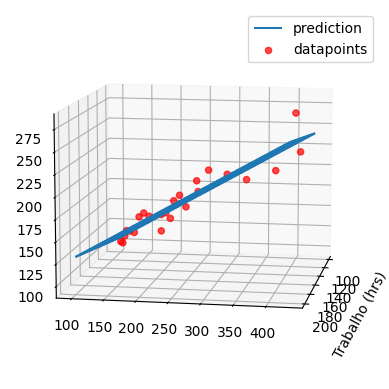

In [311]:
# Visualizando os resultados
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plot the fitted curve
ax.plot_wireframe(X, Y, Z, label = 'prediction')

# plot the target values
ax.scatter(df['L'], df['K'], df['P'], c = 'r', label = 'datapoints', alpha = 0.7)
ax.set_xlabel("Trabalho (hrs)")

ax.view_init(10, 10)
plt.legend()
plt.show()

Faremos o mesmo experimento, agora usando variáveis polinomiais.

In [326]:
df = pd.read_csv('https://raw.githubusercontent.com/leandrocl2005/calculo-2/main/data/cobb-douglas.csv')

# P (produção)
# L (qtdade trabalho em horas)
# K (capital investido)
df.head(3)

,year,P,L,K
0,1899,100,100,100
1,1900,101,105,107
2,1901,112,110,114


In [327]:
# variáveis polinomiais
P = df['L'].values
L = df['K'].values

df['P*L'] = x1 * x2
df['P*L^2'] = x1 * x2 * x2
df['P^2'] = x1 * x1
df['L*P^2'] = x1 * x1 * x2

In [328]:
df.head(3)

,year,P,L,K,P*L,P*L^2,P^2,L*P^2
0,1899,100,100,100,10000,1000000,10000,1000000
1,1900,101,105,107,11235,1202145,11025,1179675
2,1901,112,110,114,12540,1429560,12100,1379400


In [329]:
X = df.drop(["year", "P"], axis=1)
y = df["P"]

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
mean_squared_error(y_pred, y, squared=True)

74.53117776138204

Observe o quanto o ajuste melhorou.

In [330]:
# Criando a coluna de predições
z_pred = model.intercept_ + np.matmul(df.drop(['year','P'], axis=1).values, model.coef_.reshape(-1,1))
df["P_pred"] = z_pred
df[["P", "P_pred"]].tail(4)

,P,P_pred
20,218,229.363487
21,231,228.398489
22,279,263.302824
23,240,257.811715


In [331]:
# Criando a grade 2D de pontos (x, y)
x = np.arange(100, 210, 10) # usando o máximo e o mínimo de L
y = np.arange(100, 440, 10) # usando o máximo e o mínimo de K
X,Y = np.meshgrid(x,y)

Z = model.intercept_
Z += X * model.coef_[0]
Z += Y * model.coef_[1]
Z += X * Y * model.coef_[2]
Z += X * Y * Y * model.coef_[3]
Z += X * X * model.coef_[4]
Z += X * X * Y * model.coef_[5]

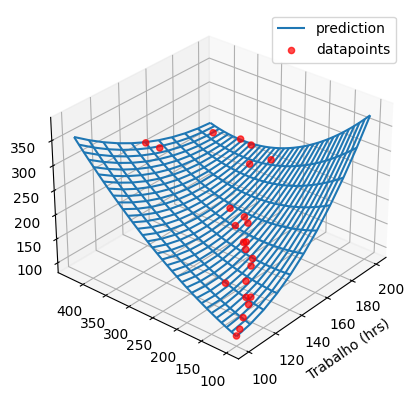

In [332]:
# Visualizando os resultados

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plot the fitted curve
ax.plot_wireframe(X, Y, Z, label = 'prediction')

# plot the target values
ax.scatter(df['L'], df['K'], df['P'], c = 'r', label = 'datapoints', alpha = 0.7)
ax.set_xlabel("Trabalho (hrs)")

ax.view_init(30, 220)
plt.legend()
plt.show()

## Referência

- https://towardsdatascience.com/dimensionality-reduction-for-machine-learning-80a46c2ebb7e
- Cobb Douglas dataset: Cálculo Vol. 2 - James Stewart - Traduação da 6ª edição norte americana